# 김형준 박사님 논문 네트워크 구현
- A novel deep learning-based forecasting model optimized by heuristic algorithm for energy management of microgrid, Applied Energy, 332 (2023)

## LSTM+GAM 구조
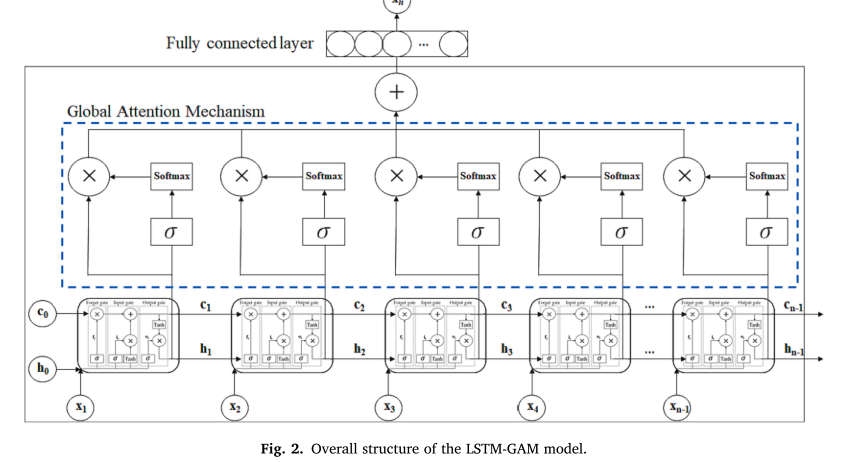
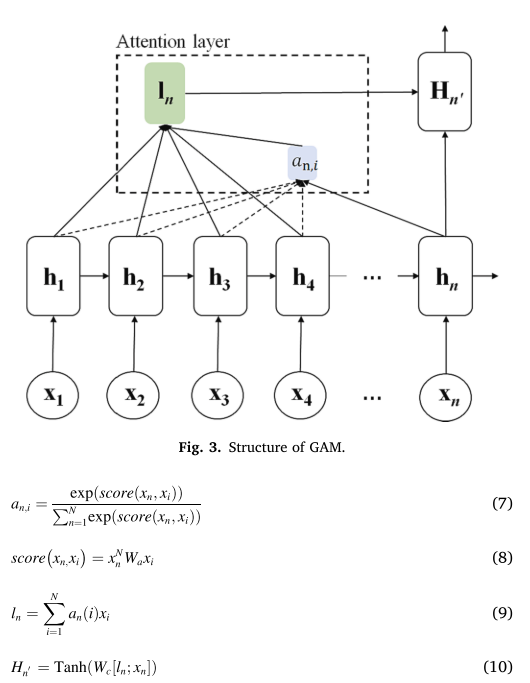

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

class GlobalAttention(nn.Module):
    def __init__(self, hidden_size):
        super(GlobalAttention, self).__init__()
        self.wa = nn.Linear(hidden_size, hidden_size, bias=False)
        self.wc = nn.Linear(hidden_size * 2, hidden_size, bias=False)

    def forward(self, hn, h):
         # 수식 (8): score(xn, xi) = xn Wa xi
        scores = torch.bmm(h, self.wa(hn).transpose(1, 2)).squeeze(2) 
        
         # 수식 (7): an,i = exp(score(xn, xi)) / sum(exp(score(xn, xi)))
        attn_weights = torch.softmax(scores, dim=1).unsqueeze(2)
        
         # 수식 (9): ln = sum(an(i)xi)
        context = torch.sum(attn_weights * h, dim=1)
        
        # 수식 (10): Hn' = Tanh(Wc[ln; xn])
        hn_prime = torch.tanh(self.wc(torch.cat((context, hn.squeeze(1)), dim=1)))
        return hn_prime

class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMWithAttention, self).__init__()
        self.lstm_layer = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = GlobalAttention(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.lstm_layer.num_layers, x.size(0), self.lstm_layer.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm_layer.num_layers, x.size(0), self.lstm_layer.hidden_size).to(x.device)
        h, _ = self.lstm_layer(x, (h_0, c_0))
        hn = h[:, -1, :].unsqueeze(1)
        hn_prime = self.attention(hn, h)
        output = self.fc(hn_prime)
        return output

In [11]:
# 하이퍼파라미터 설정
input_size = 10
hidden_size = 50
output_size = 1
num_layers = 1
learning_rate = 0.001
num_epochs = 100

# 데이터 생성
x_train = torch.randn(64, 100, input_size)  # 64개 샘플로 학습 데이터 생성
y_train = torch.randn(64, output_size)
x_val = torch.randn(16, 100, input_size)  # 16개 샘플로 검증 데이터 생성
y_val = torch.randn(16, output_size)
x_test = torch.randn(16, 100, input_size)  # 16개 샘플로 테스트 데이터 생성
y_test = torch.randn(16, output_size)


# 모델 초기화
model_lstm = LSTM(input_size, hidden_size, num_layers)
model_attention = LSTMWithAttention(input_size, hidden_size, output_size, num_layers)

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=learning_rate)
optimizer_attention = optim.Adam(model_attention.parameters(), lr=learning_rate)


In [12]:
# 학습 함수
def train_model(model, optimizer, x_train, y_train, x_val, y_val, num_epochs):
    model.train()
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # Validation loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(x_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())
        model.train()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
    
    return train_losses, val_losses

Epoch [10/100], Train Loss: 0.8997, Val Loss: 1.6124
Epoch [20/100], Train Loss: 0.8475, Val Loss: 1.6477
Epoch [30/100], Train Loss: 0.7551, Val Loss: 1.7308
Epoch [40/100], Train Loss: 0.6517, Val Loss: 1.7672
Epoch [50/100], Train Loss: 0.5074, Val Loss: 2.0908
Epoch [60/100], Train Loss: 0.3522, Val Loss: 2.4783
Epoch [70/100], Train Loss: 0.2158, Val Loss: 2.7058
Epoch [80/100], Train Loss: 0.1304, Val Loss: 3.1789
Epoch [90/100], Train Loss: 0.0679, Val Loss: 3.5023
Epoch [100/100], Train Loss: 0.0255, Val Loss: 3.6015
Epoch [10/100], Train Loss: 0.9232, Val Loss: 1.5350
Epoch [20/100], Train Loss: 0.8698, Val Loss: 1.6135
Epoch [30/100], Train Loss: 0.7530, Val Loss: 1.7518
Epoch [40/100], Train Loss: 0.5479, Val Loss: 2.2853
Epoch [50/100], Train Loss: 0.2858, Val Loss: 2.8497
Epoch [60/100], Train Loss: 0.1025, Val Loss: 2.8270
Epoch [70/100], Train Loss: 0.0300, Val Loss: 2.8270
Epoch [80/100], Train Loss: 0.0088, Val Loss: 2.7346
Epoch [90/100], Train Loss: 0.0034, Val Loss:

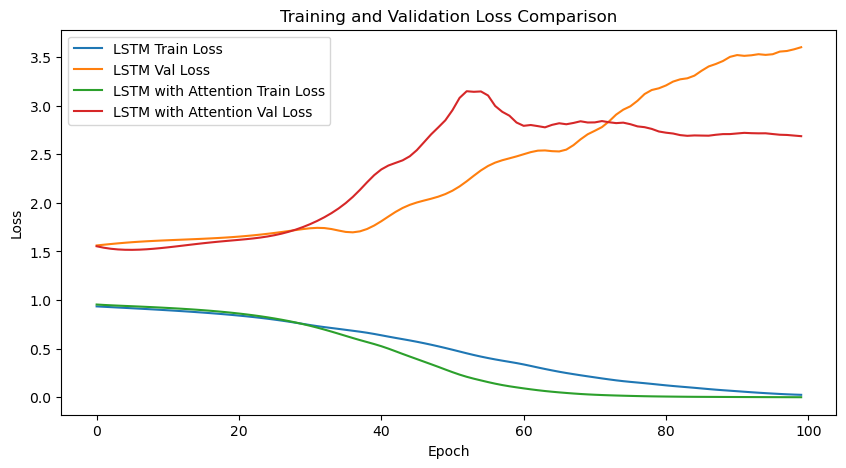

In [13]:
# 모델 학습
train_losses_lstm, val_losses_lstm = train_model(model_lstm, optimizer_lstm, x_train, y_train, x_val, y_val, num_epochs)
train_losses_attention, val_losses_attention = train_model(model_attention, optimizer_attention, x_train, y_train, x_val, y_val, num_epochs)

# 테스트 손실 계산
def test_model(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        test_outputs = model(x_test)
        test_loss = criterion(test_outputs, y_test)
    return test_loss.item()

test_loss_lstm = test_model(model_lstm, x_test, y_test)
test_loss_attention = test_model(model_attention, x_test, y_test)

print(f'Test Loss for LSTM: {test_loss_lstm:.4f}')
print(f'Test Loss for LSTM with Attention: {test_loss_attention:.4f}')

# 학습 및 검증 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses_lstm, label='LSTM Train Loss')
plt.plot(val_losses_lstm, label='LSTM Val Loss')
plt.plot(train_losses_attention, label='LSTM with Attention Train Loss')
plt.plot(val_losses_attention, label='LSTM with Attention Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.show()